<a href="https://colab.research.google.com/github/Rohit1217/IGT/blob/main/igt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib

In [ ]:
import numpy as np
import  matplotlib.pyplot as plt
import math

import torch,torchvision
from torch.utils.data import TensorDataset,DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets,transforms


In [ ]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform=transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
data=trainset.data
data_len=60000
norm = transforms.Normalize((128,),(128,))
data=data.to(dtype=torch.float32)
data=norm(data)
data_target=data*0.5+0.5
data=data*0.5+0.5
data=data.view(data_len,28*28)
data_t=data_target.view(data_len,28*28)
#data_t=torch.where(data_t > 0.5, torch.ones_like(data_t), torch.zeros_like(data_t))
new_column = torch.full((data_len, 1), -0.25)
data = torch.cat((new_column, data[:, :-1]), dim=1)
trainset=TensorDataset(data,data_t)
trainloader=DataLoader(trainset,batch_size=128,shuffle=True)
print(data[0],data_t[0])


In [ ]:
'''x=data_t[0]
x=x.view(28,28).to('cpu')

plt.imshow(x, cmap='gray')  # 'gray' colormap is used for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()'''

"x=data_t[0]\nx=x.view(28,28).to('cpu')\n\nplt.imshow(x, cmap='gray')  # 'gray' colormap is used for grayscale images\nplt.axis('off')  # Turn off axis labels\nplt.show()"

In [ ]:
class Positional_encoding(nn.Module):
  def __init__(self):
    super(Positional_encoding, self).__init__()
    return

  def forward(self,x):
    B,T,C=x.size()
    pos_emb=torch.tensor([[ math.cos(pos / 1000 ** ((2 * i +1)/ C)) if i % 2 == 1 else math.sin(pos / 1000 ** (2 * i / C)) for i in range(C)] for pos in range(T)])
    pos_emb=pos_emb.view(1,T,C)
    pos_emb=pos_emb.to(get_device())
    #print(pos_emb,x)
    return pos_emb+x

'''pos_emb=Positional_encoding()
array=torch.tensor([[[2,2,3,4,6,1],[1,2,3,4,5,5],[1,2,3,4,5,5]],[[2,2,3,4,1,1],[1,2,3,4,2,2],[1,2,3,4,5,5]]],dtype=torch.float32)
pos_emb.forward(array)'''

'pos_emb=Positional_encoding()\narray=torch.tensor([[[2,2,3,4,6,1],[1,2,3,4,5,5],[1,2,3,4,5,5]],[[2,2,3,4,1,1],[1,2,3,4,2,2],[1,2,3,4,5,5]]],dtype=torch.float32)\npos_emb.forward(array)'

In [ ]:
def mask_creator(size):
  mask=torch.ones(size,size)
  mask=torch.tril(mask)
  mask=mask.view(1,1,size,size)
  #mask[mask== 0] = float('-inf')
  return  mask
'''tensor=torch.ones(2,3,3,3)
mask=mask_creator(3)
mask*tensor'''

'tensor=torch.ones(2,3,3,3)\nmask=mask_creator(3)\nmask*tensor'

In [ ]:
class Self_Attention(nn.Module):
  def __init__(self,emb_dim,n_head,T):
    super(Self_Attention,self).__init__()

    self.emb_dim=emb_dim
    self.n_head=n_head
    self.dim=emb_dim//n_head

    self.fc_q=nn.Linear(self.emb_dim,self.emb_dim).to(get_device())
    self.fc_k=nn.Linear(self.emb_dim,self.emb_dim).to(get_device())
    self.fc_v=nn.Linear(self.emb_dim,self.emb_dim).to(get_device())
    self.fc_o=nn.Linear(self.emb_dim,self.emb_dim).to(get_device())

    self.mask1=mask_creator(T).to(get_device())
    self.register_buffer('mask',self.mask1)

  def forward(self,x):

    B,T,C=x.shape
    q,k,v=self.fc_q(x),self.fc_k(x),self.fc_v(x)
    q,k,v=q.view(B,T,self.n_head,self.dim),k.view(B,T,self.n_head,self.dim),v.view(B,T,self.n_head,self.dim)
    q,k,v=q.transpose(1,2),k.transpose(1,2),v.transpose(1,2)

    att=torch.matmul(q,k.transpose(2,3))/torch.sqrt(torch.tensor(self.dim))
    att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))

    att=F.softmax(att,dim=-1)
    att=torch.matmul(att,v)
    att=att.transpose(1,2)
    att=att.contiguous().view(B,T,self.emb_dim)
    x=self.fc_o(att)
    return x


In [ ]:
class block(nn.Module):
  def __init__(self,emb_dim,n_head,T):
    super(block,self).__init__()
    self.emb_dim=emb_dim
    self.n_head=n_head
    self.T=T
    self.atten=Self_Attention(emb_dim,n_head,T)
    self.fc1=nn.Linear(emb_dim,4*emb_dim).to(get_device())
    self.fc2=nn.Linear(4*emb_dim,emb_dim).to(get_device())
    self.ln1=nn.LayerNorm(emb_dim).to(get_device())
    self.ln2=nn.LayerNorm(emb_dim).to(get_device())
    self.d1=nn.Dropout(p=0.1)
    self.d2=nn.Dropout(p=0.1)

  def forward(self,x):
    x = x + self.atten(self.ln1(self.d1(x)))
    residual=x
    x=self.ln2(self.d2(x))
    x=F.gelu(self.fc1(x))
    x=F.gelu(self.fc2(x))
    x=x+residual
    return x

'''tensor=torch.rand(2,3,6)
atten=block(6,3,3)
tensor,atten(tensor)  '''


'tensor=torch.rand(2,3,6)\natten=block(6,3,3)\ntensor,atten(tensor)  '

In [ ]:
class iGPT(nn.Module):
  def __init__(self,emb_dim,n_head,T,n_blocks):
    super(iGPT,self).__init__()
    self.n=n_blocks
    self.emb_dim=emb_dim
    self.n_head=n_head
    self.T=T
    self.block_list = nn.ModuleList([block(self.emb_dim, self.n_head, self.T) for i in range(self.n)])
    #self.embedding=nn.Embedding(num_embeddings=257,embedding_dim=emb_dim)
    self.embedding1= nn.Linear(1,self.emb_dim)
    self.fc1= nn.Linear(self.emb_dim,256)
    self.fc2= nn.Linear(self.emb_dim,4)

  def forward(self,x):
    B,T=x.shape
    x=x.view(B,T,1)
    x=self.embedding1(x)
    pos=Positional_encoding()
    x=pos.forward(x)
    for block in self.block_list:
      x=block(x)
    #x=F.gelu(self.fc1(x))
    x=self.fc2(x)
    return x

'''tensor=torch.rand(2,36).to(get_device())
atten=iGPT(8,2,36,4).to(get_device())
#tensor,atten(tensor),atten(tensor).shape
atten(tensor)'''

'tensor=torch.rand(2,36).to(get_device())\natten=iGPT(8,2,36,4).to(get_device())\n#tensor,atten(tensor),atten(tensor).shape\natten(tensor)'

In [ ]:
lr_rate=0.001
epochs=40
model=iGPT(128,4,784,2)
model=model.to(get_device())
criterion=nn.CrossEntropyLoss()
#criterion=nn.BCELoss()
model

iGPT(
  (block_list): ModuleList(
    (0-1): 2 x block(
      (atten): Self_Attention(
        (fc_q): Linear(in_features=128, out_features=128, bias=True)
        (fc_k): Linear(in_features=128, out_features=128, bias=True)
        (fc_v): Linear(in_features=128, out_features=128, bias=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (fc1): Linear(in_features=128, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=128, bias=True)
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (d1): Dropout(p=0.1, inplace=False)
      (d2): Dropout(p=0.1, inplace=False)
    )
  )
  (embedding1): Linear(in_features=1, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

# Set hyperparameters
num_warmup_steps = 1000
num_total_steps = 10000  # Adjust based on your specific training scenario
base_learning_rate = 1e-3  # Adjust based on your specific requirements


# Create Adam optimizer
optimizer = Adam(model.parameters(), lr=base_learning_rate)

# Learning rate schedule with warmup and cosine decay
def lr_lambda(current_step):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    progress = float(current_step - num_warmup_steps) / float(max(1, num_total_steps - num_warmup_steps))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

# Set up the learning rate scheduler
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)




In [ ]:
loss_list=[]
for i in  range(epochs):
  count=0
  total_loss=0
  for input,target in trainloader:
    optimizer.zero_grad()
    input,target=input.to(get_device()),target.to(get_device())
    input,target=(input*255.0)//64,(target*255.0)//64

    pred=model(input)
    B,T,C=pred.shape
    pred=pred.view(B*T,C)
    target=target.view(B*T)
    target=target.view(B*T).long()
    loss=criterion(pred,target)
    total_loss+=loss.item()
    count+=1

    loss.backward()
    optimizer.step()
    scheduler.step()

  loss_list.append(total_loss)
  print(f'training_loss={total_loss/count},average_loss={total_loss},epoch={i}')




training_loss=0.38637622555435847,average_loss=181.21044978499413,epoch=0
training_loss=0.28050719547881753,average_loss=131.55787467956543,epoch=1
training_loss=0.20413833265619746,average_loss=95.7408780157566,epoch=2
training_loss=0.18537507697082023,average_loss=86.94091109931469,epoch=3
training_loss=0.1779183287229111,average_loss=83.4436961710453,epoch=4
training_loss=0.17270668537250713,average_loss=80.99943543970585,epoch=5
training_loss=0.16900592054258276,average_loss=79.26377673447132,epoch=6
training_loss=0.1658886922384376,average_loss=77.80179665982723,epoch=7
training_loss=0.16324992312678396,average_loss=76.56421394646168,epoch=8
training_loss=0.16084653996963744,average_loss=75.43702724575996,epoch=9
training_loss=0.15893004624955437,average_loss=74.53819169104099,epoch=10
training_loss=0.15734818240981113,average_loss=73.79629755020142,epoch=11
training_loss=0.15607837014106798,average_loss=73.20075559616089,epoch=12
training_loss=0.1549016168948684,average_loss=72.6

KeyboardInterrupt: 

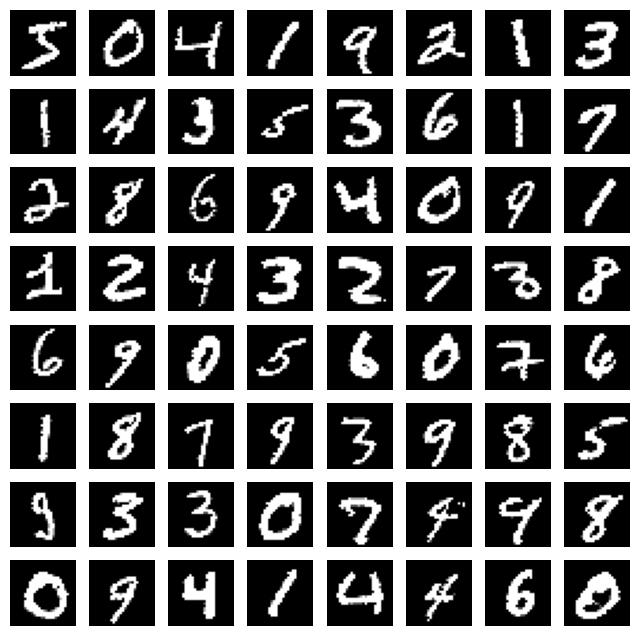

In [ ]:
x=data[:64].view(64,784).to(get_device())
x=(x*255.0)/64
#print(x.shape)
#print(x[0])
x=model(x)
#x=torch.where(x > 0.5, torch.ones_like(x), torch.zeros_like(x))
#print(x[0].view(784,256))

x=torch.argmax(x,dim=-1)
x = x[:64].view(8, 8, 28, 28)
x = x.to('cpu')
image_np = x.numpy()

# Create a figure and a set of subplots arranged in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# Iterate through the subplots and display each image
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(image_np[i, j], cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels

plt.show()

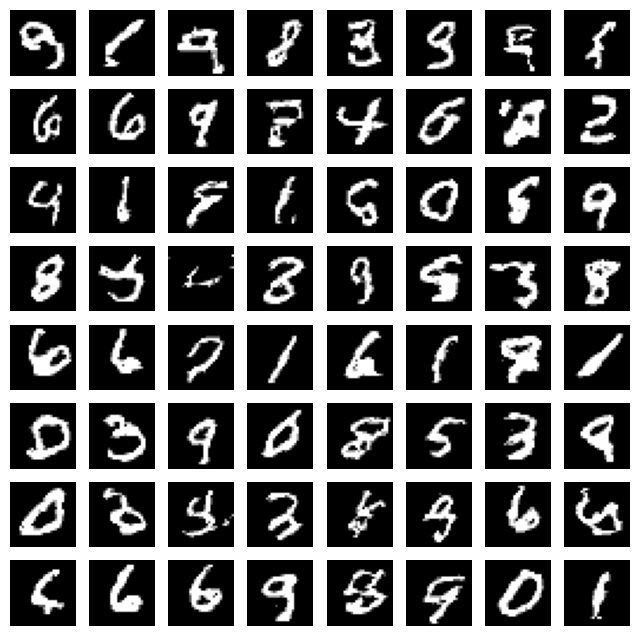

In [ ]:
x = torch.zeros(64,784)
#x=data[:64]
#print(data[0])
x[:,0]=-1
x=(x*255.0)/4
#x = 2 * x - 1

x=x.to(get_device())
y=x
#model.eval()
n=584

with torch.no_grad():
    for i in range(783):
            out = model(x)
            probs = F.softmax(out[:,i,:],dim=-1).data
            #print(probs.shape,probs,torch.multinomial(probs, 1).float().view(64))
            x[:,i+1] = (torch.multinomial(probs, 1).float()).view(64)
            #print(torch.argmax(probs[0],dim=-1))
            #print(i)



#print(x.shape,x[0])
x[:,0]=0
#x=torch.argmax(x,dim=-1)
x = x[:64].view(8, 8, 28, 28)
x = x.detach().to('cpu')
image_np = x.numpy()

# Create a figure and a set of subplots arranged in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# Iterate through the subplots and display each image
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(image_np[i, j], cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels

plt.show()